In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import combinations
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import pickle
from pyclustering.cluster.cure import cure
from tqdm.notebook import tqdm
from scipy.stats import chi2
import pandas as pd
import sys

# 1. Inspecting th data

## 1.1. Analyzing missing values

In [2]:
df = pd.read_csv('CC GENERAL.csv')
df.drop('CUST_ID', axis=1, inplace=True)
print(f'Number of entries: {df.shape[0]}')
print(df.isnull().sum())

Number of entries: 8950
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


## 1.2. We noticed some incongruences on the dataset, namely regarding the minimum payments and payment values. There were such cases where minimum payments value was grater than the payments. After careful analysis of different methods of handling this problem, e.g. substitution, complete removel, we found that removing these samples provided the best outcome in the clustering.

In [3]:
idx = df[(df['MINIMUM_PAYMENTS'].isnull()) | (df['MINIMUM_PAYMENTS'] > df['PAYMENTS'])].index
df.drop(idx, inplace=True)
print(f'Number of entries: {df.shape[0]}')
df.to_csv('CC_GENERAL_CLEANED.csv', index=False)

Number of entries: 6272


In [4]:
print(df.isnull().sum())

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


## 1.3. Correlations between between paramaters of our vector space

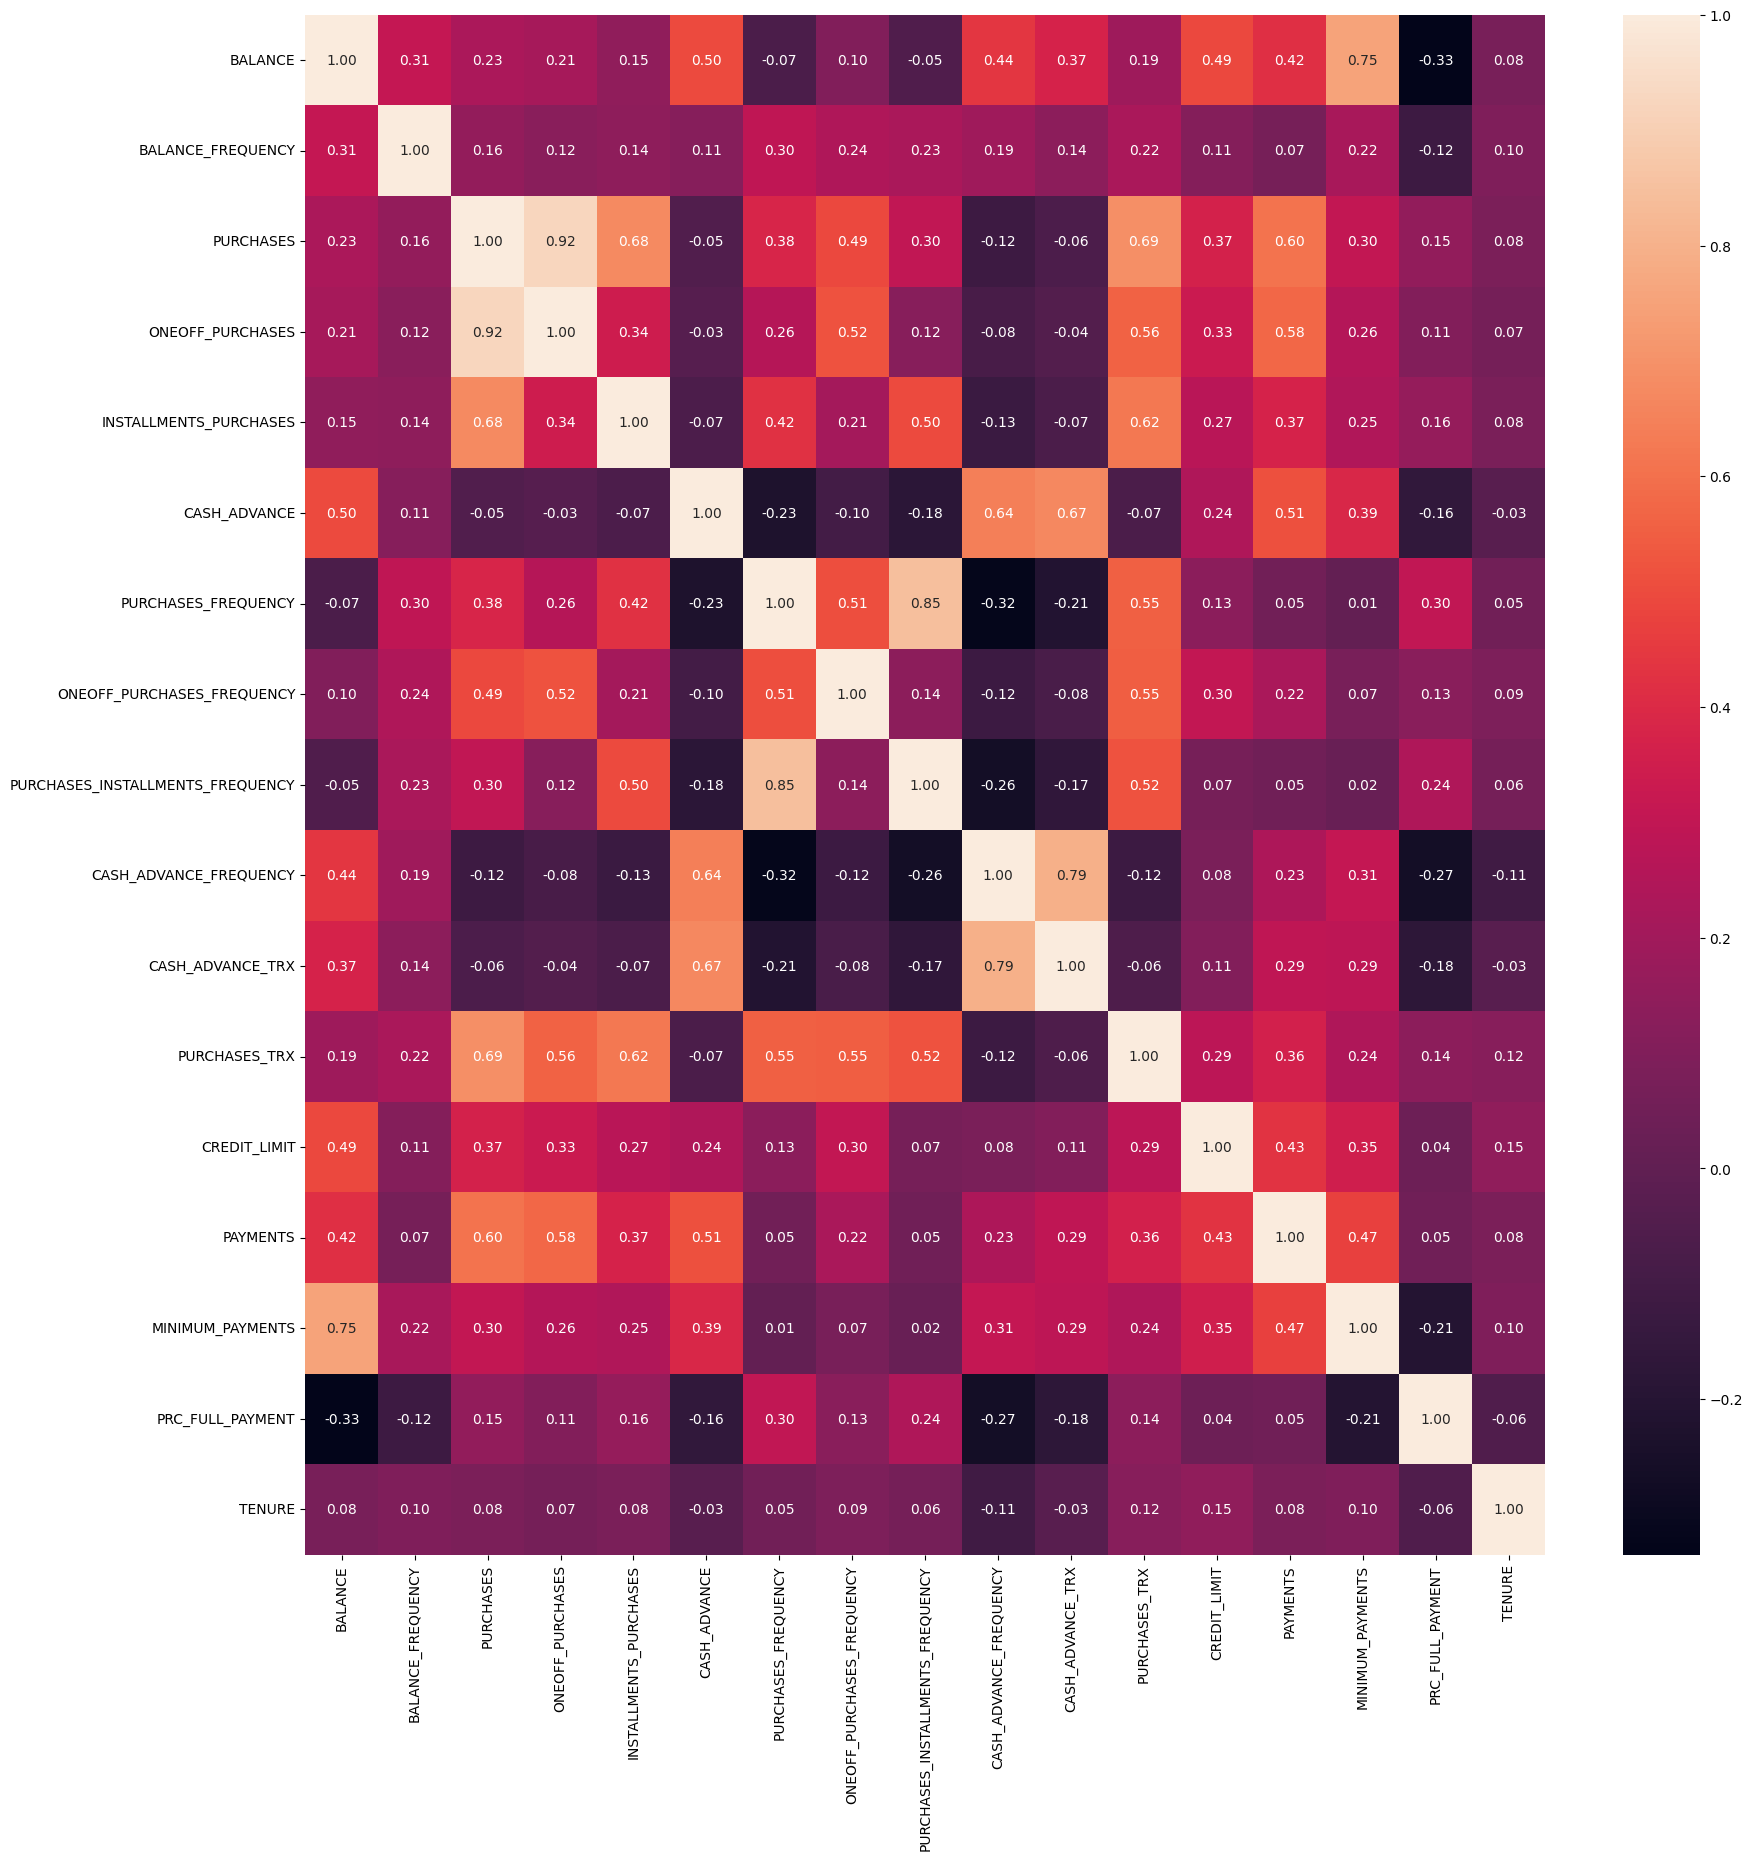

In [5]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, fmt='.2f')
plt.show()

## 1.4. Histogram of each component of the vector space

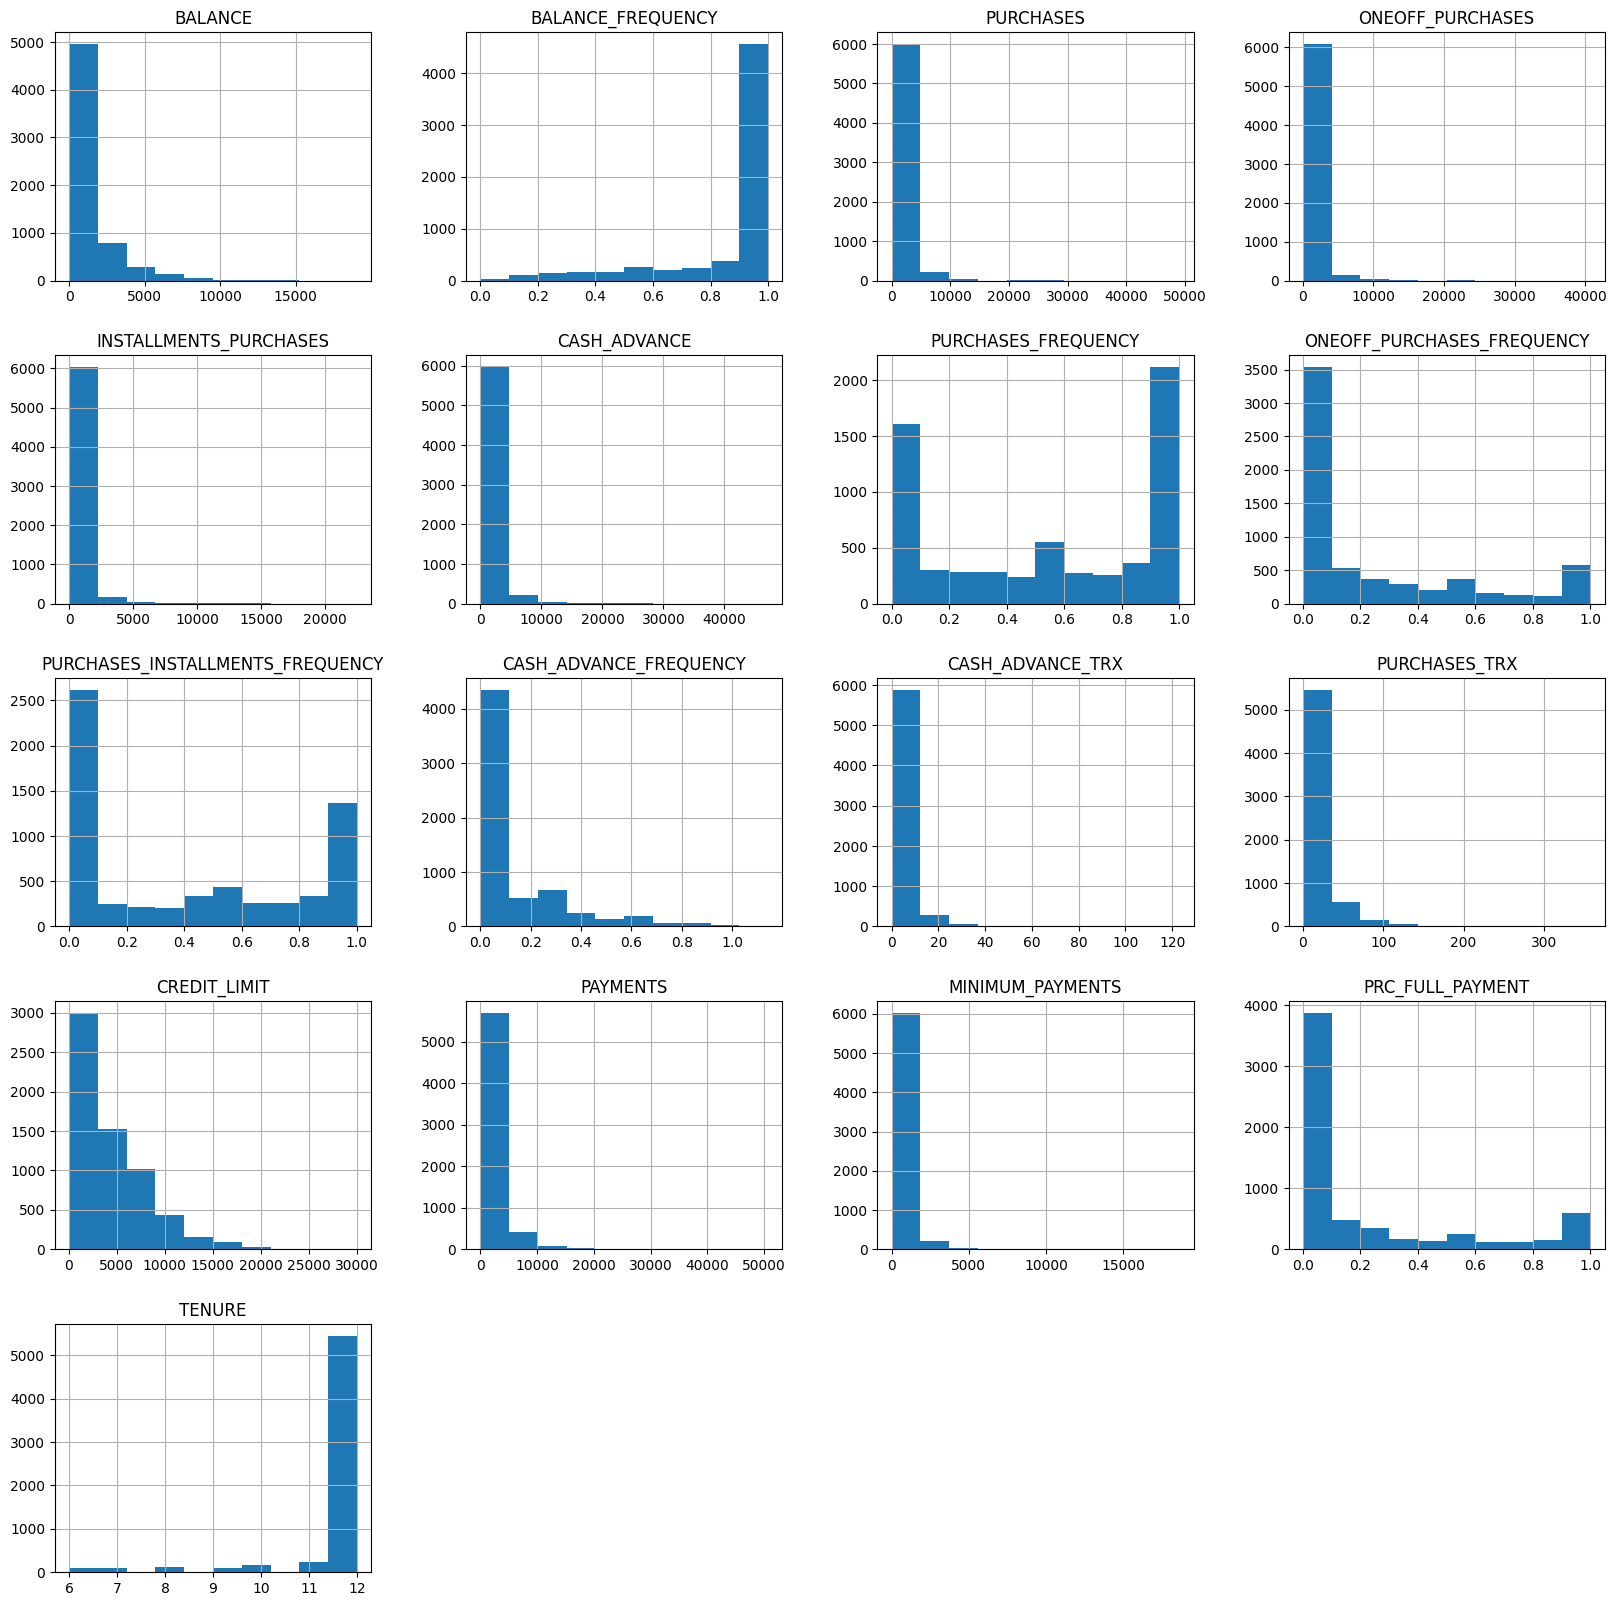

In [6]:
df.hist(figsize=(20, 20))
plt.show()

## 1.5. Even though BFR was not applicable to this dataset, because the data is not gaussian, we computed the mean and standard deviation using techniques suggested in this BFR without the need to load the whole dataset into memory.

In [7]:
class ColumnStatistics:
    def __init__(self, name):
        self.name = name
        self.N = 0
        self.sum = 0
        self.sum2 = 0
    
    def get_mean(self):
        return self.sum / self.N
    
    def get_std(self):
        return np.sqrt(self.sum2 / self.N - (self.sum / self.N) ** 2)
    
    def get_N(self):
        return self.N
    

def get_statistics(path_to_csv):
    i = -1
    columns = []
    for line in open(path_to_csv):
        if i == -1:
            columns = line.strip().split(',')[1:]
            statistics = {column: ColumnStatistics(column) for column in columns}
        else:
            values = line.strip().split(',')[1:]
            for j in range(0,len(values)):
                if values[j] == '':
                    continue
                statistics[columns[j]].N += 1
                statistics[columns[j]].sum += float(values[j])
                statistics[columns[j]].sum2 += float(values[j]) ** 2
        i += 1
    return statistics

stats = get_statistics('CC_GENERAL_CLEANED.csv')
for stat in stats.keys():
    print(f"{stat}, N: {stats[stat].get_N()}, Mean: {stats[stat].get_mean():.2f}, Std: {stats[stat].get_std():.2f}")

BALANCE_FREQUENCY, N: 6272, Mean: 0.88, Std: 0.22
PURCHASES, N: 6272, Mean: 1213.19, Std: 2428.63
ONEOFF_PURCHASES, N: 6272, Mean: 724.77, Std: 1901.20
INSTALLMENTS_PURCHASES, N: 6272, Mean: 488.72, Std: 999.47
CASH_ADVANCE, N: 6272, Mean: 920.55, Std: 2207.59
PURCHASES_FREQUENCY, N: 6272, Mean: 0.54, Std: 0.40
ONEOFF_PURCHASES_FREQUENCY, N: 6272, Mean: 0.24, Std: 0.32
PURCHASES_INSTALLMENTS_FREQUENCY, N: 6272, Mean: 0.40, Std: 0.40
CASH_ADVANCE_FREQUENCY, N: 6272, Mean: 0.12, Std: 0.20
CASH_ADVANCE_TRX, N: 6272, Mean: 2.96, Std: 7.12
PURCHASES_TRX, N: 6272, Mean: 17.10, Std: 27.01
CREDIT_LIMIT, N: 6272, Mean: 4733.73, Std: 3747.75
PAYMENTS, N: 6272, Mean: 2148.49, Std: 3285.23
MINIMUM_PAYMENTS, N: 6272, Mean: 475.52, Std: 757.36
PRC_FULL_PAYMENT, N: 6272, Mean: 0.21, Std: 0.33
TENURE, N: 6272, Mean: 11.61, Std: 1.19


In [8]:
with open('stats.pkl', 'wb') as f:
    pickle.dump(stats, f)

## 1.6. Analyzing how silhouette scores differ with the amount of samples taken from the dataset and see if samples provide a good clustering estimator tendency

In [9]:
def get_silhouette_scores(path_to_csv, stats):

    number_lines = sum(1 for _ in open(path_to_csv)) - 1

    number_initial_samples = [2**i for i in range(8,int(np.log2(number_lines)))]
    num_clusters = [2,5,10] + [i for i in range(25, 251, 25)]
    silhouette_scores = {}

    for n in tqdm(number_initial_samples):

        chosen_indices = np.random.choice(number_lines, n, replace=False)
        i=-1
        data = []
        headers = []

        for line in open(path_to_csv):
            if i == -1:
                headers = line.strip().split(',')[1:]
            elif i in chosen_indices:
                values = line.strip().split(',')[1:]
                for j,v in enumerate(values):
                    if v == '':
                        values[j] = stats[headers[j]].get_mean()
                    else:
                        values[j] = float(v)
                data.append(values)
            i += 1

        data = np.array(data)
        silhouette_scores[n] = {}

        for n_clusters in tqdm(num_clusters):
            silhouette_scores[n][n_clusters] = {}
            clustering = AgglomerativeClustering(n_clusters=n_clusters).fit_predict(data)
            silhouette_scores[n][n_clusters]['complete'] = silhouette_score(data, clustering)
            clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='single').fit_predict(data)
            silhouette_scores[n][n_clusters]['single'] = silhouette_score(data, clustering)
            clustering = KMeans(n_clusters=n_clusters).fit_predict(data)
            silhouette_scores[n][n_clusters]['kmeans'] = silhouette_score(data, clustering)

    return silhouette_scores

In [10]:
path_to_csv = 'CC_GENERAL_CLEANED.csv'    
stats = pickle.load(open('stats.pkl', 'rb'))    
silhouette_scores = get_silhouette_scores(path_to_csv, stats)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [11]:
with open('silhouette_scores.pkl', 'wb') as f:
    pickle.dump(silhouette_scores, f)

In [12]:
def plot_silhouete_scores(silhouette_scores):
    for n in silhouette_scores.keys():
        plt.figure(figsize=(20, 10))
        plt.title(f'Silhouette scores for different number of clusters using {n} samples')
        plt.plot(list(silhouette_scores[n].keys()), [v['single'] for v in silhouette_scores[n].values()], label='single linkage')
        plt.plot(list(silhouette_scores[n].keys()), [v['complete'] for v in silhouette_scores[n].values()], label='complete linkage')
        plt.plot(list(silhouette_scores[n].keys()), [v['kmeans'] for v in silhouette_scores[n].values()], label='kmeans')

        max_score = float('-inf')
        best_n_clusters = None
        best_algo = None
        for k,v in silhouette_scores[n].items():
            for algo, score in v.items():
                if score > max_score:
                    max_score = score
                    best_n_clusters = k
                    best_algo = algo
                    
        plt.scatter(best_n_clusters, max_score, color='red', label=f'Best score: {max_score:.2f} with {best_n_clusters} clusters using {best_algo}')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette score')
        plt.legend()
        plt.grid()
        plt.savefig('silhouette_scores_'+str(n)+'.png')
        plt.show()

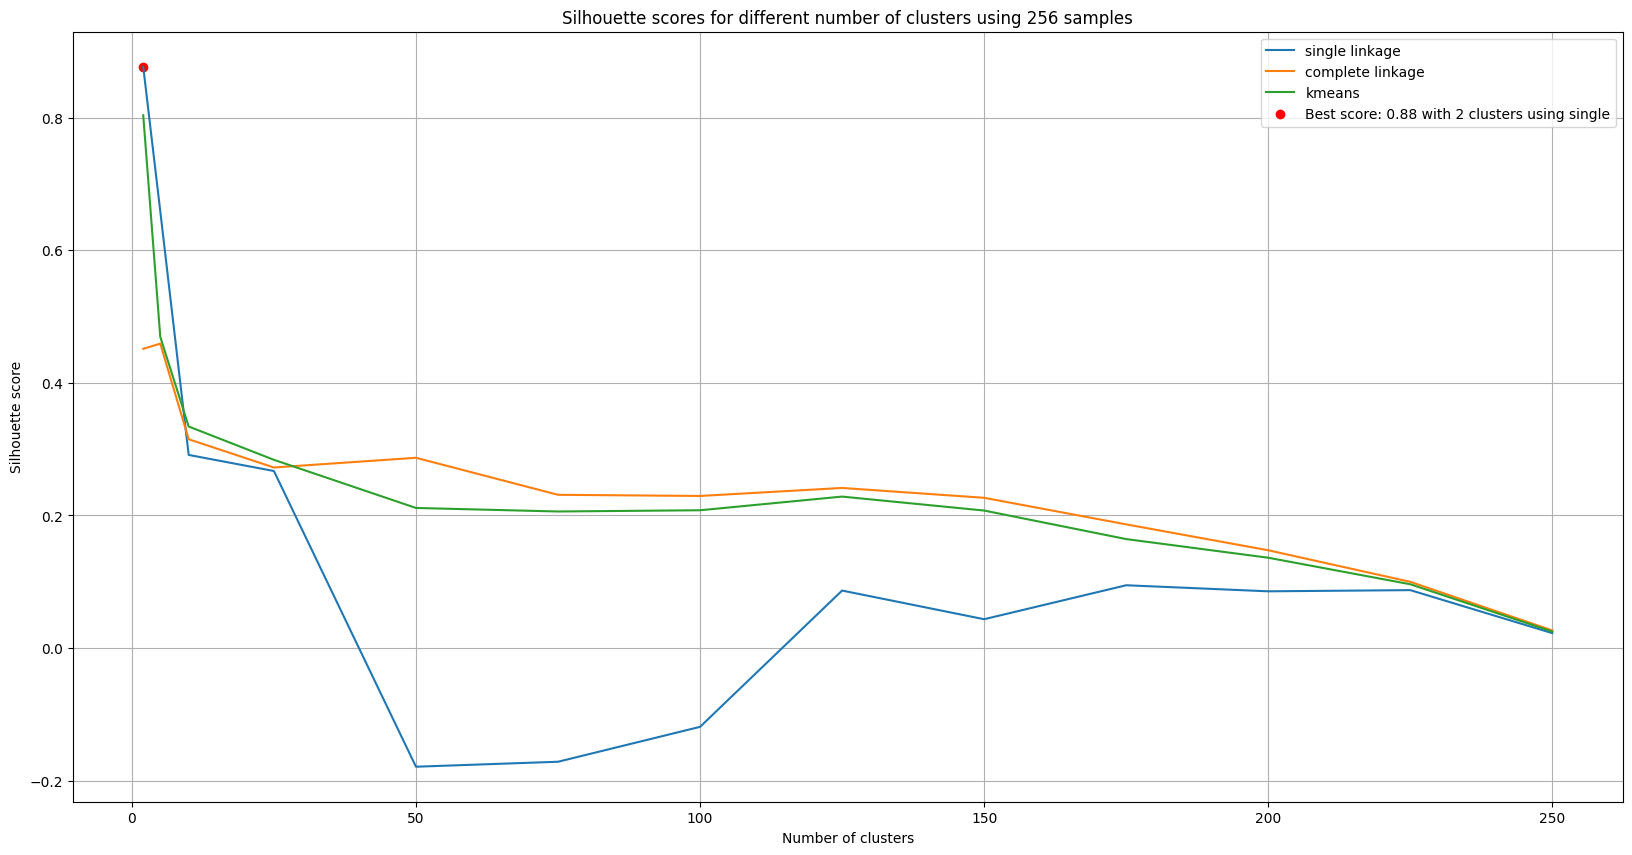

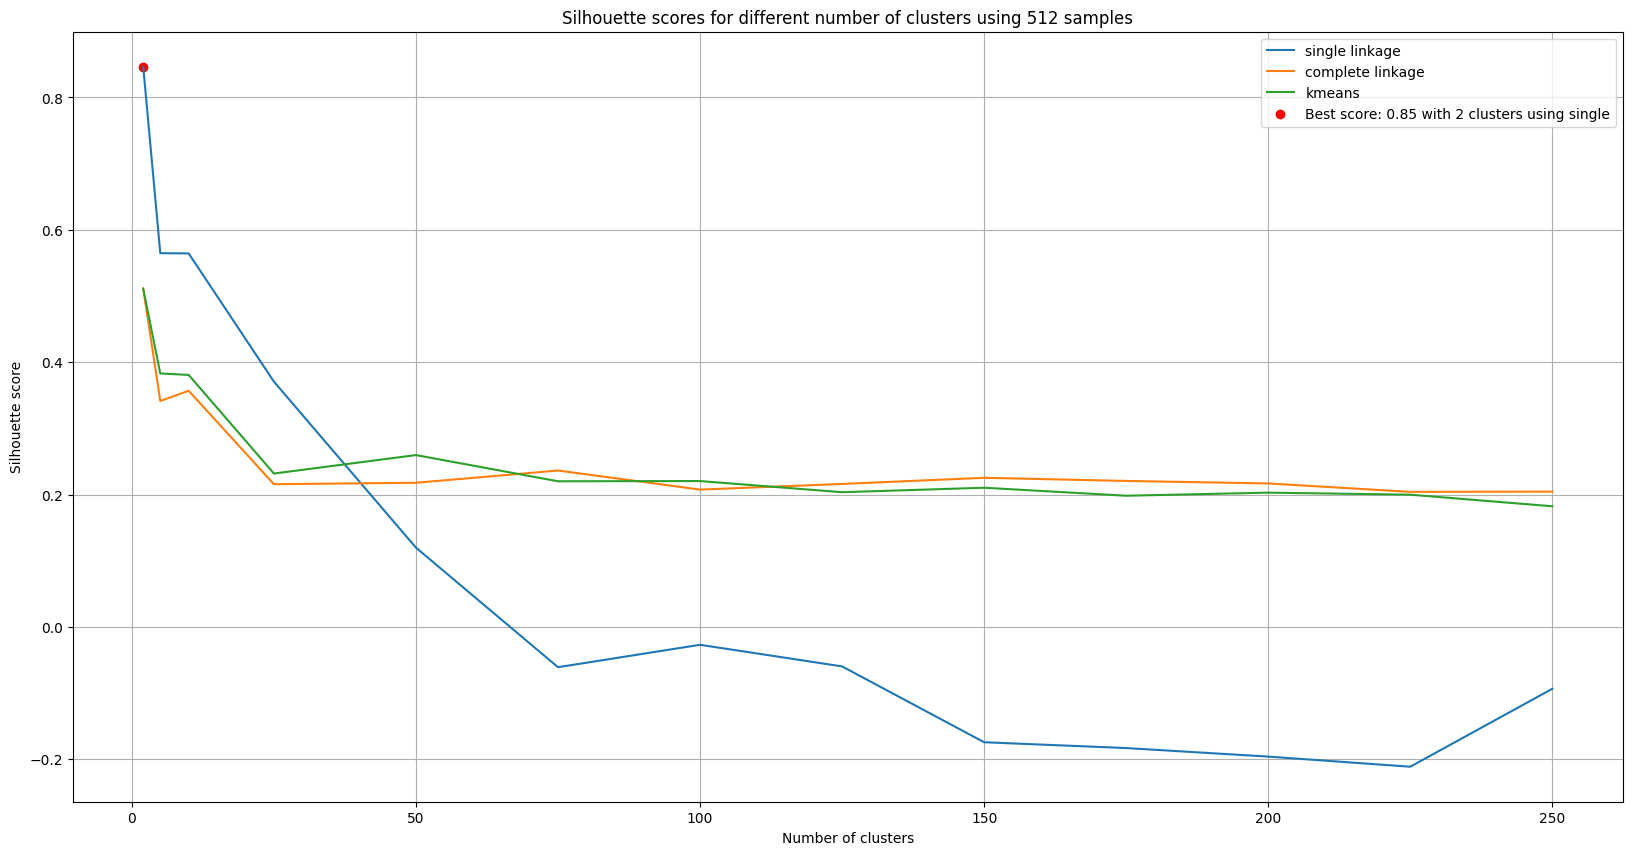

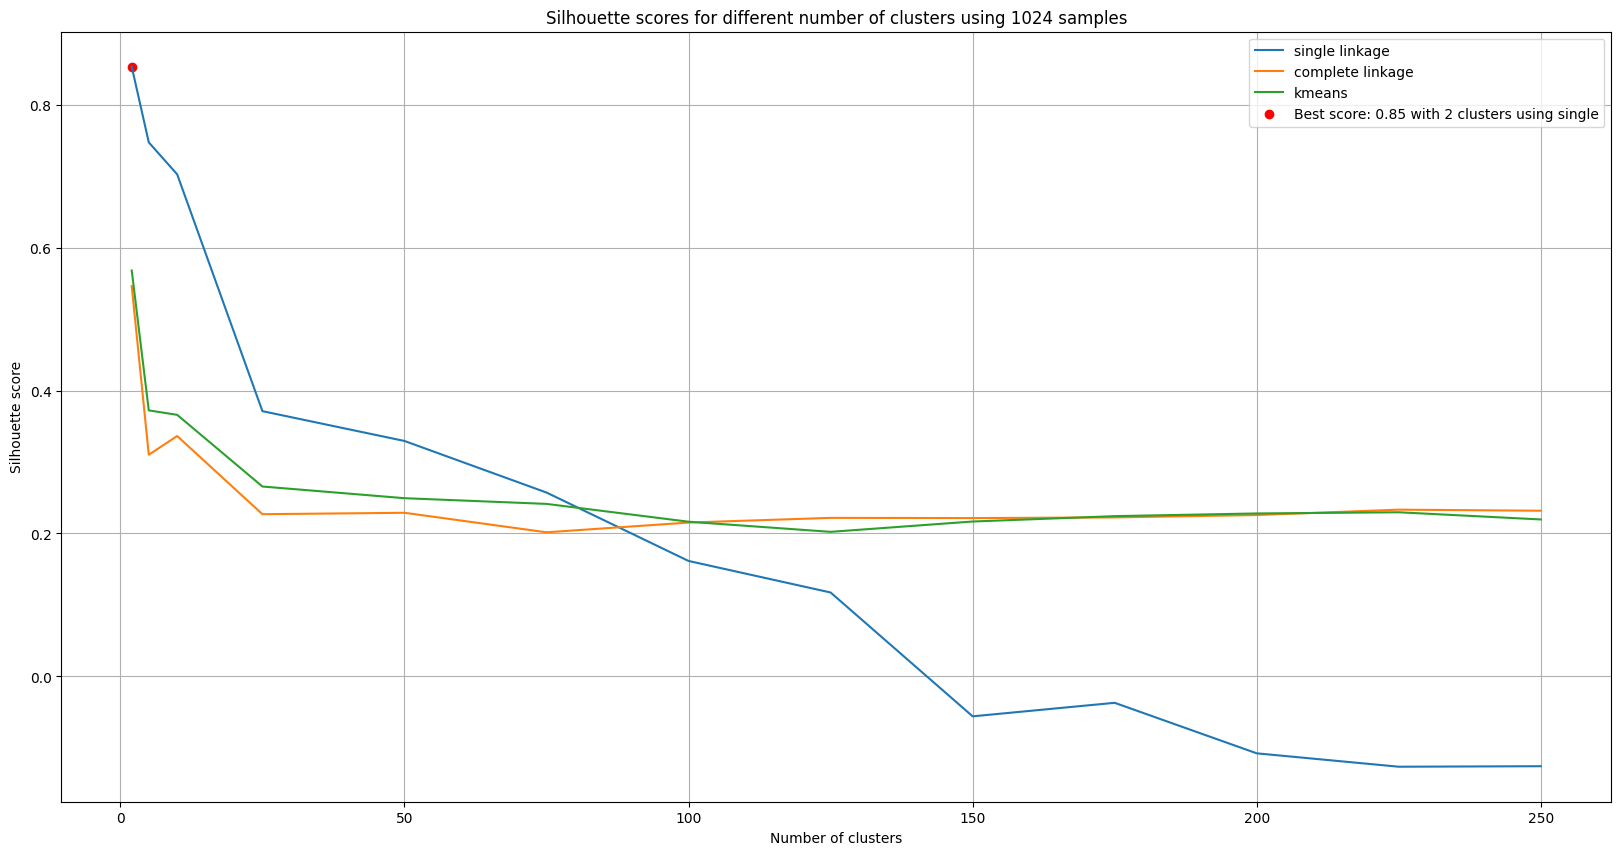

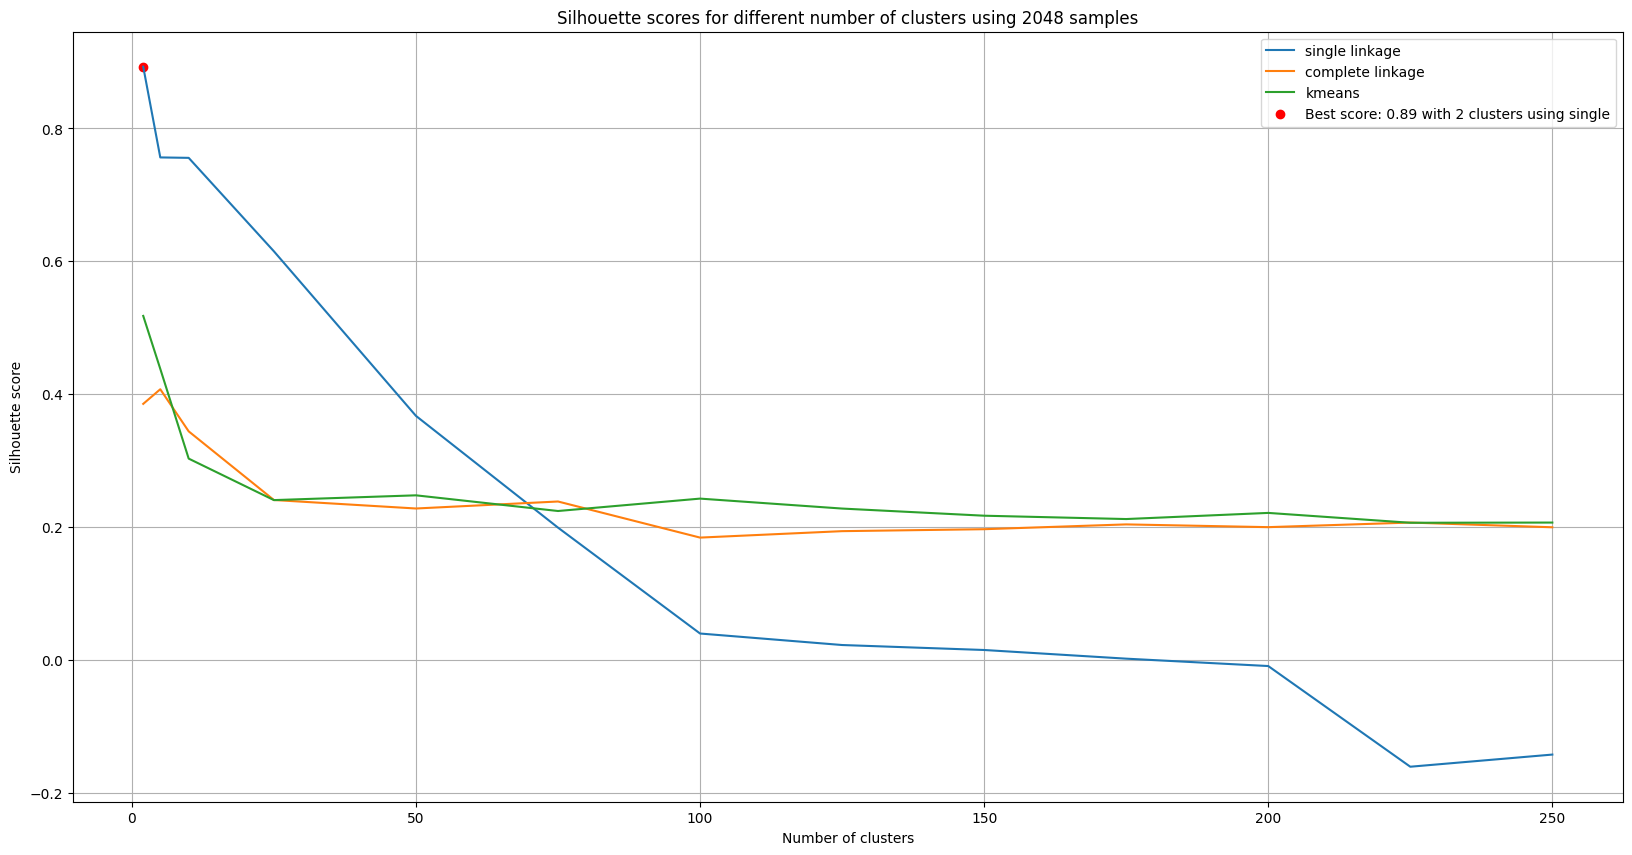

In [13]:
plot_silhouete_scores(silhouette_scores)

### From the above plots we can see that a clustering composed of 2 clusters might provide the best results according to the silhouette score.

## 1.7. Choosing a sampling number and applying cure clustering with parameters described under.

In [14]:
def get_data(path_to_csv, number_initial_samples, stats):
    
    number_lines = sum(1 for _ in open(path_to_csv)) - 1
    chosen_indices = np.random.choice(number_lines, number_initial_samples, replace=False)
    i=-1
    data = {}
    headers = []

    for line in open(path_to_csv):
        if i == -1:
            headers = line.strip().split(',')[1:]
        elif i in chosen_indices:
            values = line.strip().split(',')[1:]
            for j,v in enumerate(values):
                if v == '':
                    values[j] = stats[headers[j]].get_mean()
                else:
                    values[j] = float(v)
            data[i] = values
        i += 1
    return data

def get_cure_clusters(data, number_clusters, number_reps, alpha):
    idxs = sorted(list(data.keys()))
    temp_data = [data[i] for i in idxs]
    clustering = cure(temp_data, number_clusters, number_reps, alpha)
    clustering.process()

    clusters = {}
    for i in range(number_clusters):
        clusters[i] = {'reps': clustering.get_representors()[i]}
        clusters[i]['points'] = [idxs[j] for j in clustering.get_clusters()[i]]

    return clusters

In [62]:
path_to_file = 'CC_GENERAL_CLEANED.csv'
stats = pickle.load(open('stats.pkl', 'rb'))

number_initial_samples = 2048
num_clusters = 2
num_reps = 10
alpha = 0.3

data = get_data(path_to_file, number_initial_samples, stats)
clustering = get_cure_clusters(data, num_clusters, num_reps, alpha)

In [63]:
save_name = 'CURE_'+str(num_clusters)+'_'+str(num_reps)+'_'+str(alpha)+'.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clustering, f)

## 1.7.1. Classifying the rest of the dataset with the resultant clustering

In [64]:
def get_closest_CURE_cluster(point, clusters):
    min_dist = float('inf')
    closest_cluster = None
    for cluster in clusters.keys():
        for rep in clusters[cluster]['reps']:
            dist = np.linalg.norm(np.array(point) - np.array(rep))
            if dist < min_dist:
                min_dist = dist
                closest_cluster = cluster
    return closest_cluster

path_to_file = 'CC_GENERAL_CLEANED.csv'

i=-1
idxs = list(data.keys())
stats = pickle.load(open('stats.pkl', 'rb'))
headers = []

for line in open(path_to_file):
    if i == -1:
        headers = line.strip().split(',')[1:]
    elif i not in idxs:
        values = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                values[j] = stats[headers[j]].get_mean()
            else:
                values[j] = float(v)
        closest_cluster = get_closest_CURE_cluster(values, clustering)
        clustering[closest_cluster]['points'].append(i)
    i += 1
    

In [65]:
for k,v in clustering.items():
    print(len(v['points']))

6252
20


In [67]:
save_name = 'FULL_CURE_'+str(num_clusters)+'_'+str(num_reps)+'_'+str(alpha)+'.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clustering, f)

# 2.

## 2.1. As we saw, using 2 clusters provided the best silhouette score across all. We can also notice that the clusters are very imbalance. This might be due to the presence of outliers. As such, we have to perform an analysis on outliers using a metric like the mahalanobis distance. In order to compute the mahalanobis distance we need to compute the covariance matrix of the dataset. To keep up with the trend of Data Analytics procedures, we need then to see if we can find a viable estimator for this matrix.

In [68]:
covariance_matrices = []

path_to_file = 'CC_GENERAL_CLEANED.csv'
number_lines = sum(1 for _ in open(path_to_file)) - 1
stats = pickle.load(open('stats.pkl', 'rb'))

for i in range(10):
    chosen_indices = np.random.choice(number_lines, 1000, replace=False)
    headers = []
    i=-1
    data = []
    for line in open(path_to_file):
            if i == -1:
                headers = line.strip().split(',')[1:]
            elif i in chosen_indices:
                values = line.strip().split(',')[1:]
                for j,v in enumerate(values):
                    if v == '':
                        values[j] = stats[headers[j]].get_mean()
                    else:
                        values[j] = float(v)
                data.append(values)
            i += 1
    data = np.array(data)
    covariance_matrix = np.cov(data.T)
    covariance_matrices.append(covariance_matrix)


mean_covariance_matrix = np.mean(covariance_matrices, axis=0)
mean_diff = 0
for cov in covariance_matrices:
    mean_diff += np.sum(cov - mean_covariance_matrix)
mean_diff /= len(covariance_matrices)
print(mean_diff)

-2.2351741790771484e-09


From the above cell we can see that the mean difference across various covariance matrices estimators (resulting from sampling) result in a very low value, which is indicative of a negligable variance. In other words, sampling provides a good estimar for a covariance matrix.

## 2.2. Next we need to implement the mahalanobis distance based on the mean of the sampled covariance matrices.

In [69]:
def mahalanobis_distance(point, mean_vector, covariance_matrix):
    return np.sqrt((point - mean_vector).T @ np.linalg.inv(covariance_matrix) @ (point - mean_vector))

path_to_file = 'CC_GENERAL_CLEANED.csv'
number_lines = sum(1 for _ in open(path_to_file)) - 1
stats = pickle.load(open('stats.pkl', 'rb'))
headers = []
i=-1
data = []
mean_vec = np.array([stats[header].get_mean() for header in stats.keys()])
mahalanobis_distances = {}

for line in open(path_to_file):
    if i == -1:
        headers = line.strip().split(',')[1:]
    else:
        values = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                values[j] = stats[headers[j]].get_mean()
            else:
                values[j] = float(v)
        values = np.array(values)
        mahalanobis_distances[i] = mahalanobis_distance(values, mean_vec, mean_covariance_matrix)
    i += 1

mean_mahalanobis = np.mean(list(mahalanobis_distances.values()))
std_mahalanobis = np.std(list(mahalanobis_distances.values()))
print(f'Mean: {mean_mahalanobis:.2f}, Std: {std_mahalanobis:.2f}')

Mean: 3.36, Std: 2.19


## 2.3. Mahalanobis distances of a dataset always generate an histogram of a chi squared distribution, as follows.

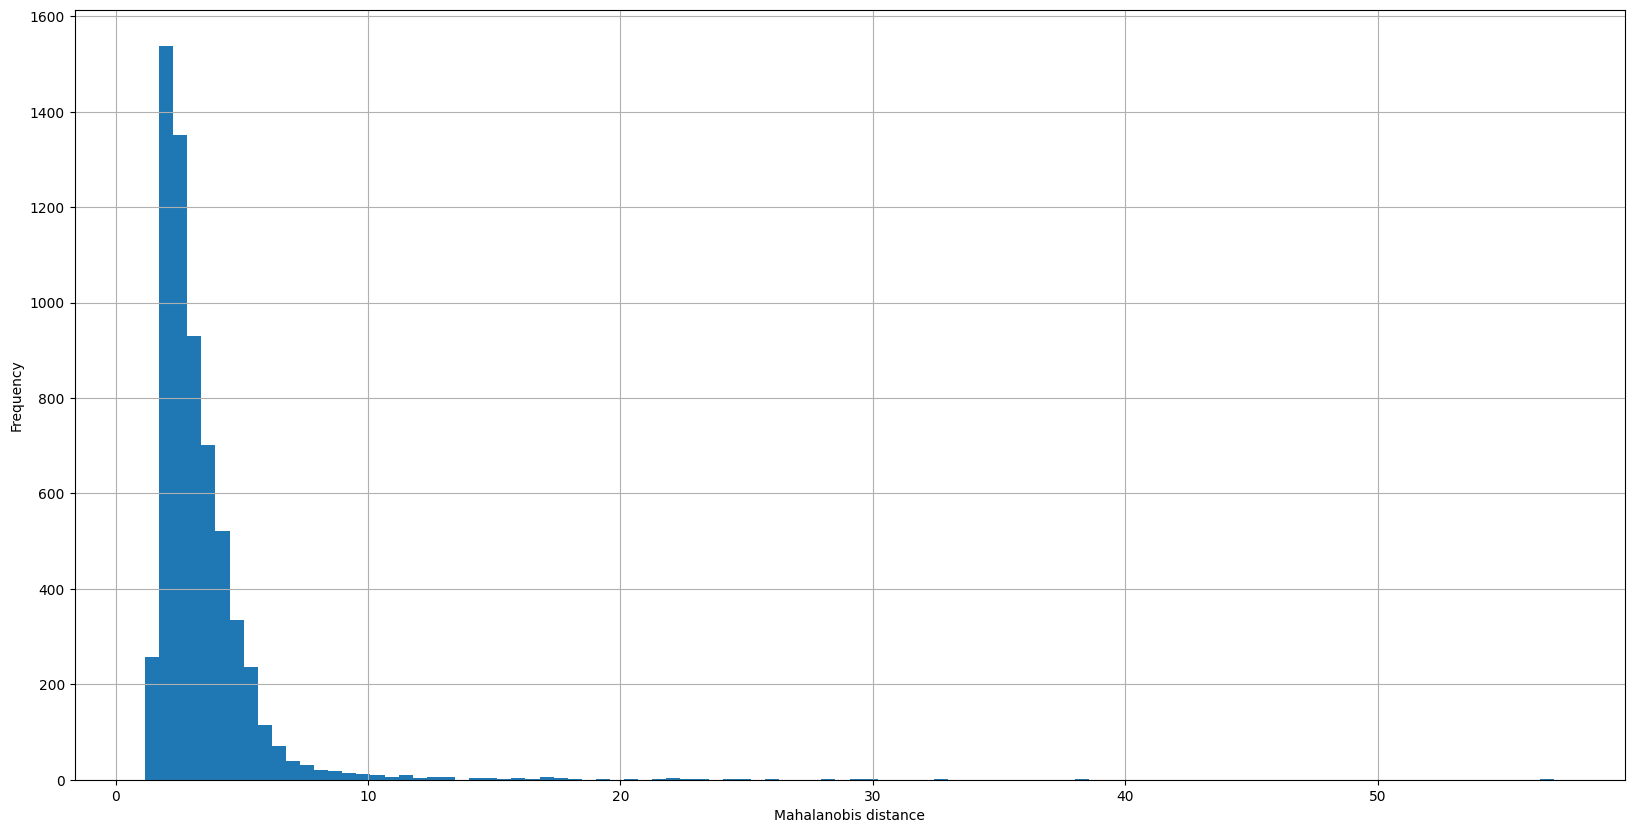

In [70]:
plt.figure(figsize=(20, 10))
plt.hist(list(mahalanobis_distances.values()), bins=100)
plt.xlabel('Mahalanobis distance')
plt.ylabel('Frequency')
plt.grid()

## 2.4. According to the paper by Rousseeuw and Van Zomeren (1990), (https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/mahal?action=AttachFile&do=view&target=chisqoutlier.pdf), a good threshold to detect outliers can be the value of Chi Squared distribution with k degrees of freedom and probability 0.99, where k is the number of parameters such that threshold = X_2(k,0.99)

In [71]:
threshold = chi2.ppf(0.99, 13)
print(f'Threshold: {threshold:.2f}')
outliers = [k for k,v in mahalanobis_distances.items() if v > threshold]
print(f'Number of outliers: {len(outliers)}')
print(f'Outliers: {outliers}')
print(clustering[1]['points'])

Threshold: 27.69
Number of outliers: 6
Outliers: [82, 334, 1489, 3695, 3719, 4807]
[180, 2752, 1136, 846, 4939, 82, 334, 339, 367, 394, 642, 790, 991, 1075, 1095, 1110, 2062, 2576, 2958, 3787]


In [72]:
# sanity check
all = []
for k,v in clustering.items():
    all = all + v['points']
print(len(all))

6272


In [73]:
i=-1
with open('CC_GENERAL_CLEANED_NO_OUTLIERS.csv', 'w') as f:
    for line in open('CC_GENERAL_CLEANED.csv'):
        if i not in outliers:
            f.write(line)
        i += 1

## 2.5. Next thing to do we to recompute the clustering after having removed the outliers.

In [74]:
path_to_csv = 'CC_GENERAL_CLEANED_NO_OUTLIERS.csv'
stats = get_statistics('CC_GENERAL_CLEANED_NO_OUTLIERS.csv')
silhouette_scores = get_silhouette_scores(path_to_csv, stats)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [75]:
with open('silhouette_scores_no_outliers.pkl', 'wb') as f:
    pickle.dump(silhouette_scores, f)

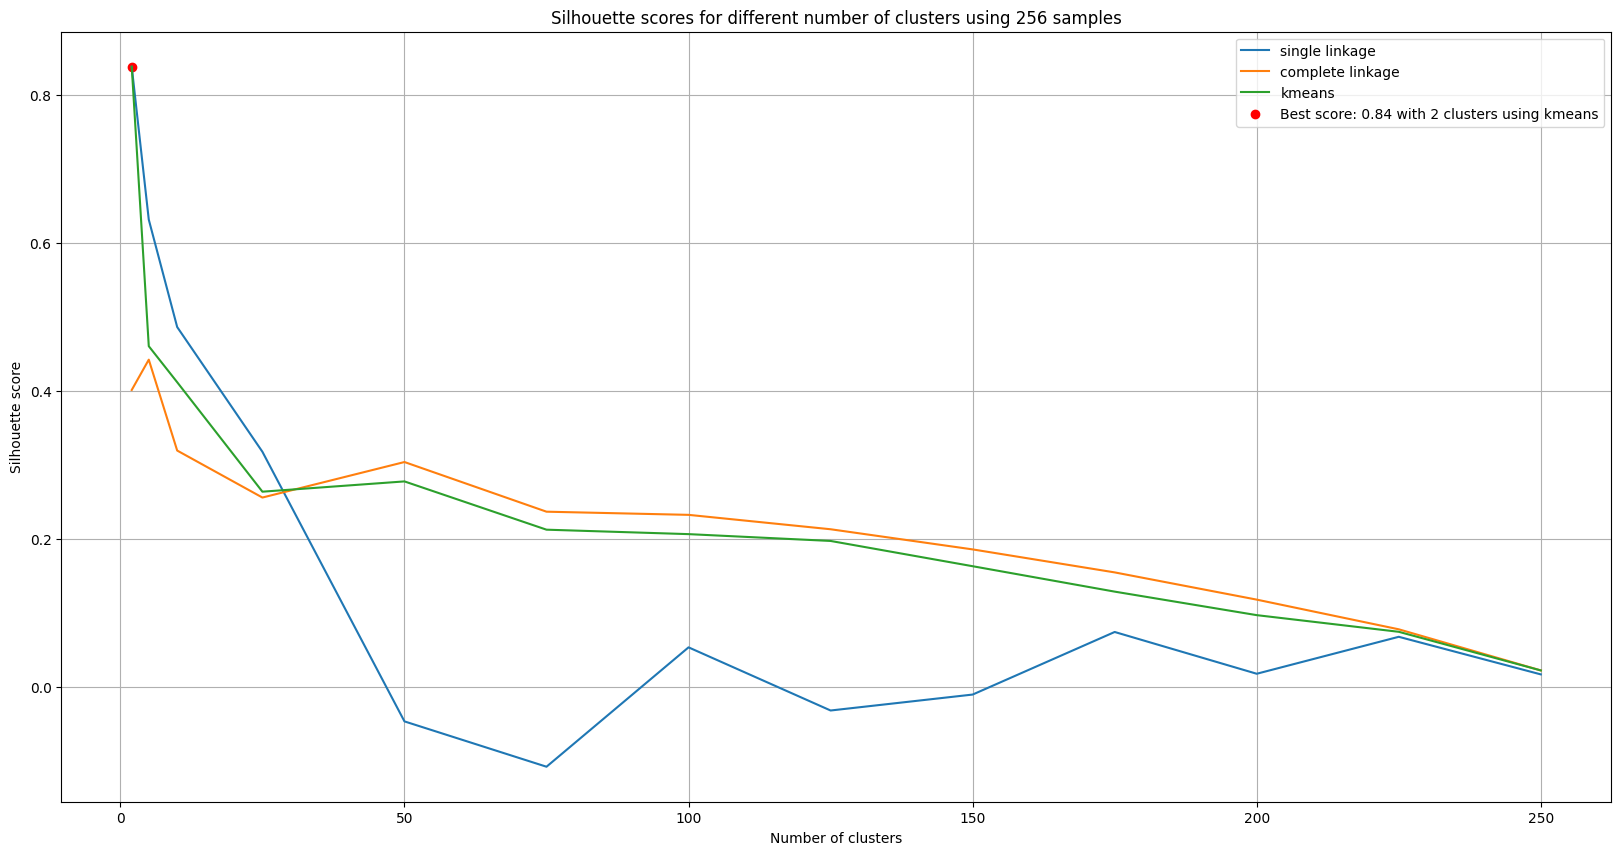

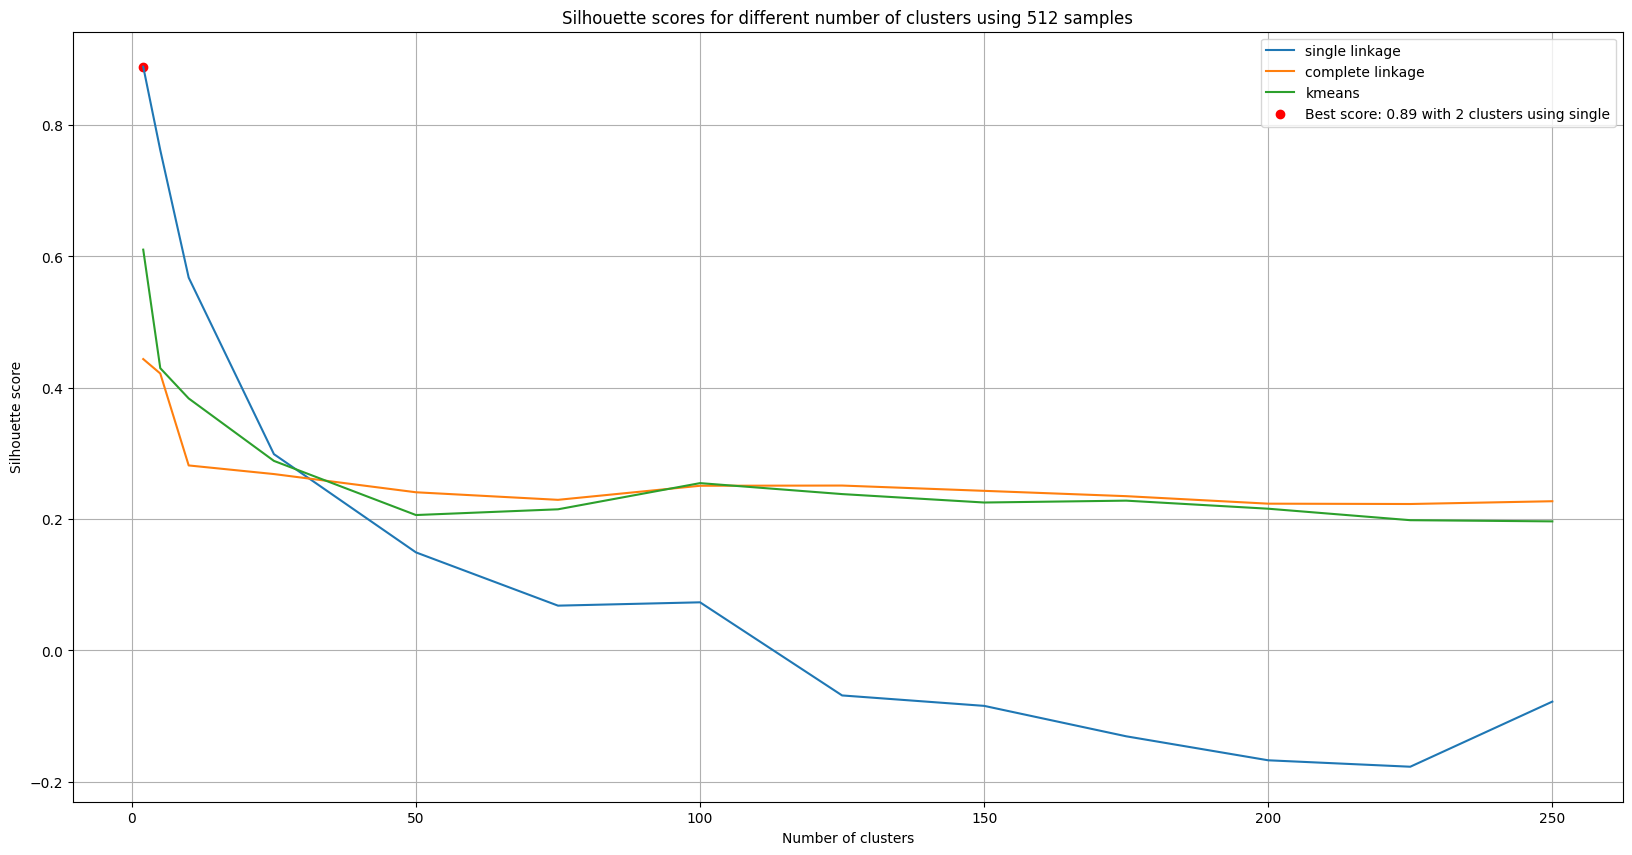

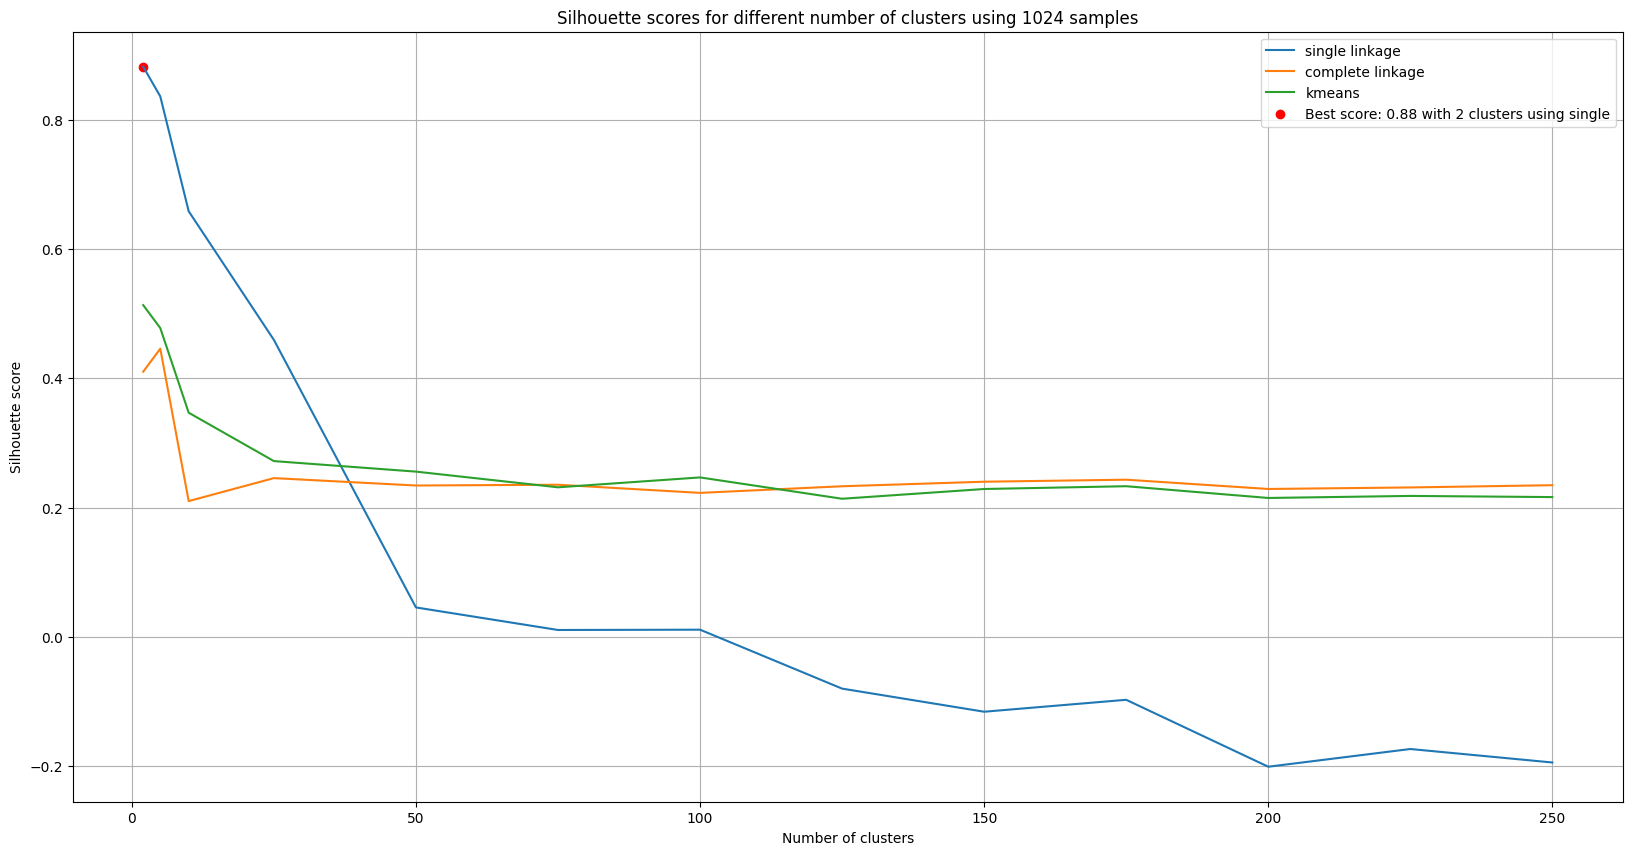

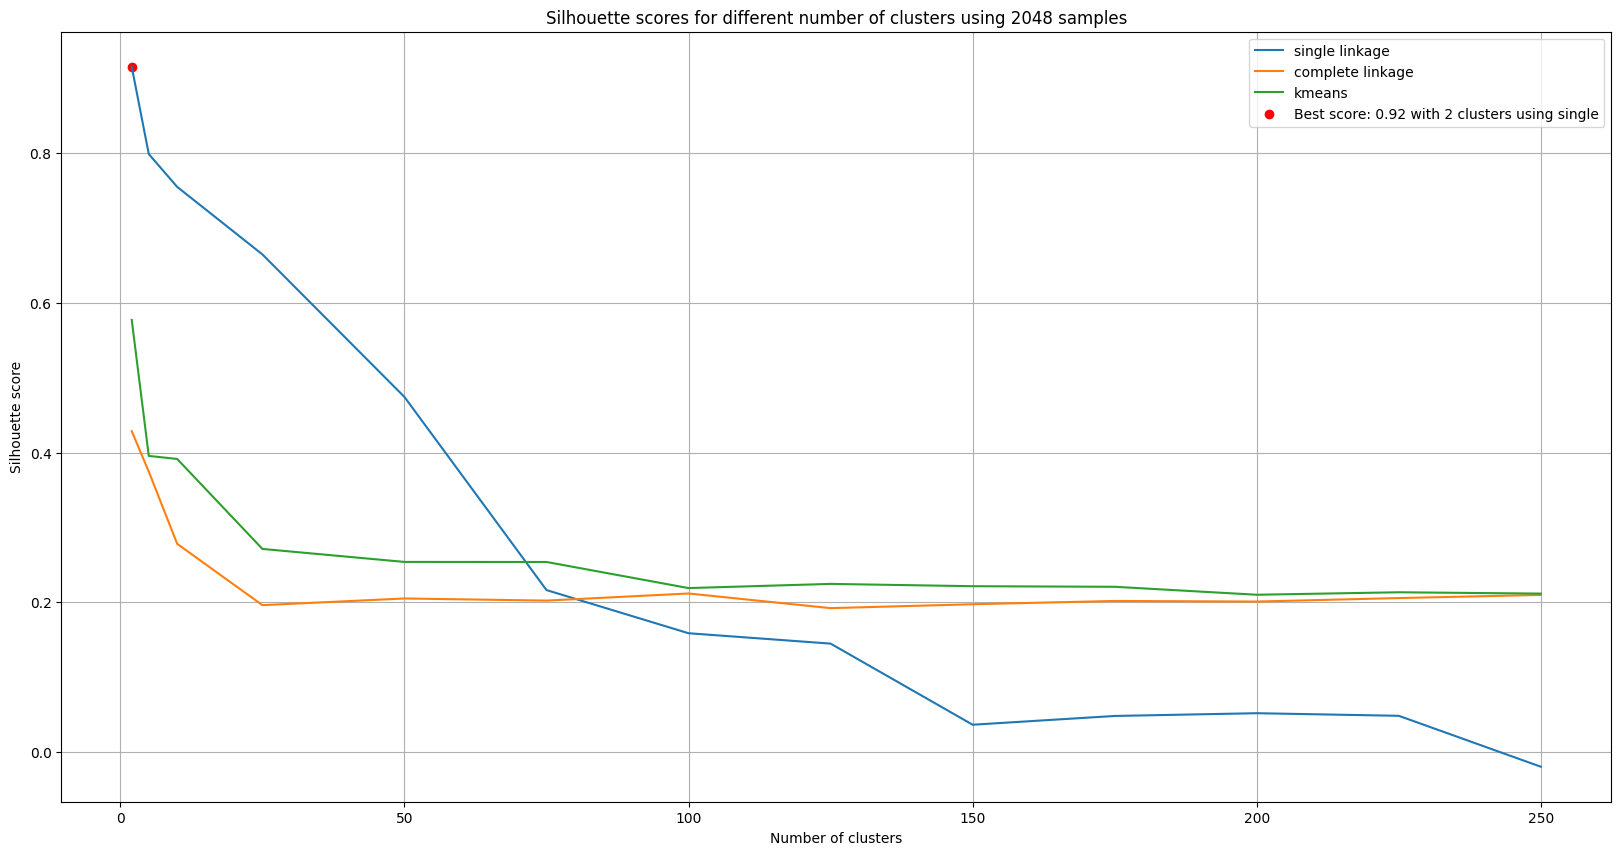

In [76]:
plot_silhouete_scores(silhouette_scores)

In [82]:
path_to_file = 'CC_GENERAL_CLEANED_NO_OUTLIERS.csv'
stats = get_statistics(path_to_file)
number_lines = sum(1 for _ in open(path_to_file)) - 1

number_initial_samples = 1024
num_clusters = 2
num_reps = 10
alpha = 0.5

data = get_data(path_to_file, number_initial_samples, stats)
clustering = get_cure_clusters(data, num_clusters, num_reps, alpha)

In [83]:
save_name = 'CURE_'+str(num_clusters)+'_'+str(num_reps)+'_'+str(alpha)+'_no_outliers.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clustering, f)

In [84]:
path_to_file = 'CC_GENERAL_CLEANED_NO_OUTLIERS.csv'

i=-1
idxs = list(data.keys())
stats = get_statistics(path_to_file)
headers = []

for line in open(path_to_file):
    if i == -1:
        headers = line.strip().split(',')[1:]
    elif i not in idxs:
        values = line.strip().split(',')[1:]
        for j,v in enumerate(values):
            if v == '':
                values[j] = stats[headers[j]].get_mean()
            else:
                values[j] = float(v)
        closest_cluster = get_closest_CURE_cluster(values, clustering)
        clustering[closest_cluster]['points'].append(i)
    i += 1

In [85]:
for k,v in clustering.items():
    print(len(v['points']))

24
6242


In [86]:
save_name = 'FULL_CURE_'+str(num_clusters)+'_'+str(num_reps)+'_'+str(alpha)+'_no_outliers.pkl'
with open(save_name, 'wb') as f:
    pickle.dump(clustering, f)

We can see that the clustering ever so slightly improved. There are is stil an imbalance present but it turns that this is just what the data is representing and nothing more can be done about this.

# 3.
## 3.1. As discussed before, we cannot use BFR on this dataset because it doesn't have an inherent gaussian distribution. Therefore, to provide a base of comparison we used the 3 known clustering algorithms: K-means, Agglomerative with complete linkage, Agglomerative with single linkage

In [88]:
path_to_file = 'CC_GENERAL_CLEANED_NO_OUTLIERS.csv'
df = pd.read_csv(path_to_file)

kmeans = KMeans(n_clusters=2).fit_predict(df.values)
agglo_complete = AgglomerativeClustering(n_clusters=2).fit_predict(df.values)
agglo_single = AgglomerativeClustering(n_clusters=2, linkage='single').fit_predict(df.values)

df['kmeans'] = kmeans
df['agglo_complete'] = agglo_complete
df['agglo_single'] = agglo_single

print(df['kmeans'].value_counts())
print(df['agglo_complete'].value_counts())
print(df['agglo_single'].value_counts())

print(f'kmeans silhouette score: {silhouette_score(df.values, kmeans):.2f}')
print(f'agglo complete silhouette score: {silhouette_score(df.values, agglo_complete):.2f}')
print(f'agglo single silhouette score: {silhouette_score(df.values, agglo_single):.2f}')

kmeans
0    5026
1    1240
Name: count, dtype: int64
agglo_complete
1    3632
0    2634
Name: count, dtype: int64
agglo_single
0    6265
1       1
Name: count, dtype: int64
kmeans silhouette score: 0.53
agglo complete silhouette score: 0.36
agglo single silhouette score: 0.87


The silhouette score of each of the three clustering methods is in accordance with our previously estimated silhouette scores as a result from smapling. In specific, if we look at single linkage, whihc holds the highest silhouette score, we can see that the clusters are very imbalanced as expected. Hence, our clustering estimator using CURE algorithm provided a good result under these circumstances.